In [87]:
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage import graph
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import tifffile as tf
from sklearn import decomposition, preprocessing
from ripser import ripser
import persim

dst = '../proc/emb/'
dpi = 150
savekw = {'dpi':dpi, 'bbox_inches':'tight', 'pad_inches':0}

In [150]:
time = '4pm'
rep = 7
plant = 0
max_idx = 340

src = '../proc/prelim/{}_rep{}/plant_{:02d}/'.format(time, rep, plant)
idx = 366
filename = src + '{}_rep{:02d}_{:04d}.tif'.format(time, rep, idx)
img = tf.imread(filename)

<tifffile.TiffFile '4pm_rep07_0366.tif'> invalid shaped series metadata or corrupted file


In [ ]:
time = '4pm'
rep = 1
plant = 0
max_idx = 340

src = '../proc/prelim/{}_rep{}/plant_{:02d}/'.format(time, rep, plant)
imgs = [None for _ in range(max_idx)]
for idx in range(1, max_idx+1):
    filename = src + '{}_rep{:02d}_{:04d}.tif'.format(time, rep, idx)
    imgs[idx - 1] = tf.imread(filename)

In [3]:
def sk_cuscuta(img, thr=199):
    cuscuta = img > thr
    xlims = np.nonzero(np.any(cuscuta, axis=0))[0][[0,-1]]
    ylims = np.nonzero(np.any(cuscuta, axis=1))[0][[0,-1]]
    cuscuta = np.pad(cuscuta[ ylims[0]:ylims[1]+1, xlims[0]:xlims[1]+1], 10)
    return cuscuta, xlims, ylims

def g_leaves(cuscuta):
    g, nodes = graph.pixel_graph(cuscuta, connectivity=2)
    leaves = np.sort(np.nonzero(g.count_nonzero(axis=0) == 1)[0])
    if len(leaves) < 2:
        g, nodes = graph.pixel_graph(cuscuta, connectivity=1)
        leaves = np.sort(np.nonzero(g.count_nonzero(axis=0) == 1)[0])
    leaves = [np.unravel_index(n, cuscuta.shape) for n in nodes[leaves]]
    return leaves

def c_path(cuscuta, leaves):
    lix = np.argmax(np.asarray(leaves)[:,0])
    start = leaves[lix]

    costs = (~cuscuta).astype(np.uint8)
    mcp = graph.MCP(costs, fully_connected=True)
    _ = mcp.find_costs(starts = [start])
    
    coords = []
    for i in np.setdiff1d(range(len(leaves)), lix):
        path = mcp.traceback(leaves[i])
        if len(path) > len(coords):
            coords = path
    coords = np.stack(coords, axis=-1).T
    return coords

def coordinate(coords, L=25):
    step = len(coords)/L
    approx = []
    i = 0
    while i < len(coords):
        approx.append(coords[int(i)])
        i += step
    if np.any(approx[-1] != coords[-1]):
        approx.append(coords[-1])
    approx = np.asarray(approx)
    return approx

def c_angle(approx):
    rads = np.zeros(len(approx)-1)
    for i in range(len(rads)):
        v = approx[i+1] - approx[i]
        rads[i] = np.arccos(v[0]/np.linalg.norm(v))

    rads -= 0.5*np.pi
    degs = np.rad2deg(rads)
    return rads, degs

In [151]:
#idx = 300
#img = imgs[idx]

cuscuta = img > 199
xlims = np.nonzero(np.any(cuscuta, axis=0))[0][[0,-1]]
ylims = np.nonzero(np.any(cuscuta, axis=1))[0][[0,-1]]
cuscuta = np.pad(cuscuta[ ylims[0]:ylims[1], xlims[0]:xlims[1]], 10)

print(img.shape, xlims, ylims, xlims[1]-xlims[0], ylims[1]-ylims[0], cuscuta.shape, np.round(100*cuscuta.size/img.size, 2), sep='\t')

(838, 399)	[ 81 352]	[272 751]	271	479	(499, 291)	43.43


In [152]:
g, nodes = graph.pixel_graph(cuscuta, connectivity=2)
leaves = np.sort(np.nonzero(g.count_nonzero(axis=0) == 1)[0])
if len(leaves) < 2:
    g, nodes = graph.pixel_graph(cuscuta, connectivity=1)
    leaves = np.sort(np.nonzero(g.count_nonzero(axis=0) == 1)[0])
print(leaves, len(nodes))
leaves = [np.unravel_index(n, cuscuta.shape) for n in nodes[leaves]]
print(leaves)

[ 60  73 195 649] 650
[(17, 189), (18, 280), (48, 100), (488, 98)]


In [153]:
lix = np.argmax(np.asarray(leaves)[:,0])
start = leaves[lix]

costs = (~cuscuta).astype(np.uint8)
mcp = graph.MCP(costs, fully_connected=True)
cost, path = mcp.find_costs(starts = [start])

coords = []
for i in np.setdiff1d(range(len(leaves)), lix):
    path = mcp.traceback(leaves[i])
    if len(path) > len(coords):
        coords = path
coords = np.stack(coords, axis=-1).T
print(coords[ list(range(4)) + list(range(-4,0))], '\n')

[[488  98]
 [487  97]
 [486  97]
 [485  96]
 [ 18 277]
 [ 19 278]
 [ 19 279]
 [ 18 280]] 



In [154]:
L = 15
x = np.linspace(0,1,L)
step = len(coords)/L
i = 0
approx = []
while i < len(coords):
    approx.append(coords[int(i)])
    i += step
if np.any(approx[-1] != coords[-1]):
    approx.append(coords[-1])
approx = np.asarray(approx)
print(approx[ list(range(4)) + list(range(-4,0))], '\n')

[[488  98]
 [446  87]
 [403  65]
 [360  48]
 [ 25 152]
 [ 20 195]
 [ 11 238]
 [ 18 280]] 



In [155]:
rad = np.zeros(len(approx)-1)
for i in range(len(rad)):
    v = approx[i+1] - approx[i]
    rad[i] = np.arccos(v[0]/np.linalg.norm(v))

rad -= 0.5*np.pi
deg = np.rad2deg(rad)
print(deg, '\n')

[75.32360686 62.90444751 68.42869281 68.42869281 78.17851166 82.05652819
 83.36748538 87.33699923 66.16125982 49.63546343 30.17352003 15.59281094
  6.63251462 11.82148834 -9.46232221] 



In [156]:
foo = coords.copy()
foo[:, 0] = np.max(foo[:,0]) - foo[:,0]
foo[:, 1] = foo[:, 1] - foo[0,1]

cusc = approx.copy()
cusc[:, 0] = np.max(cusc[:,0]) - cusc[:,0]
cusc[:, 1] = cusc[:, 1] - cusc[0,1]

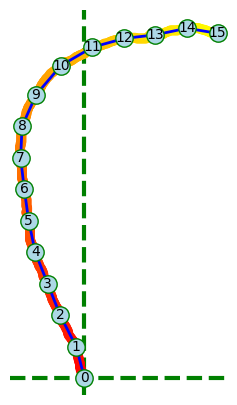

In [166]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_aspect('equal')
ax[i].set_facecolor('gainsboro')
ax[i].axis('off')
ax[i].axhline(0, c='green', ls='--', lw=3, zorder=1)
ax[i].axvline(0, c='green', ls='--', lw=3, zorder=1)

ax[i].scatter(foo[:,1], foo[:,0], c=range(len(foo)), cmap='autumn', zorder=2)
ax[i].plot(cusc[:,1], cusc[:,0], c='b', lw=2, marker ='o', ms=12.5, mfc='lightblue', mec='green', zorder=3);
for j in range(len(cusc)):
    ax[i].text(cusc[j,1], cusc[j,0], j, zorder=4, ha='center', va='center')


filename = dst + 'cuscuta_midaxis.pdf'
plt.savefig(filename, format='pdf', **savekw)

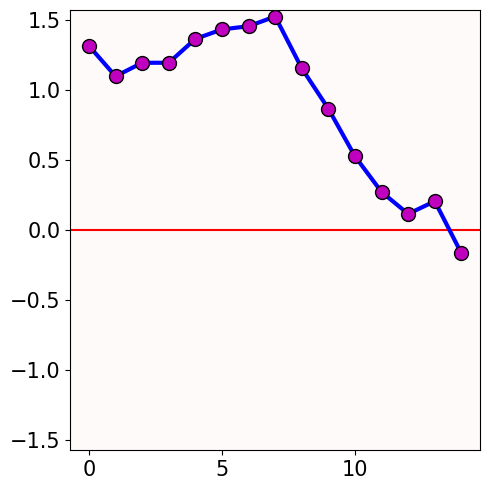

In [67]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].axhline(0, c='r', zorder=1);
ax[i].plot(range(len(rad)), rad, marker='o', mec='k', mfc='m', c='b', lw=3, ms=10, zorder=2)

ax[i].set_ylim(-0.5*np.pi, 0.5*np.pi)
ax[i].set_facecolor('snow')
ax[i].tick_params(labelsize=15)

fig.tight_layout();
filename = dst + 'cuscuta_angle.pdf'
plt.savefig(filename, format='pdf', **savekw)

# Function

In [ ]:
rads, degs, approxs = [ [ None for _ in range(len(imgs)) ] for _ in range(3) ]
L = 15
for idx in range(len(imgs)):
    img = imgs[idx]
    cuscuta, xlims, ylims =  sk_cuscuta(img, thr=199)
    leaves = g_leaves(cuscuta)
    coords = c_path(cuscuta, leaves)
    approx = coordinate(coords, L=L)
    rad, deg =  c_angle(approx)
    approxs[idx] = approx
    rads[idx] = rad
    degs[idx] = deg

cuscutas = [ approxs[idx].copy() for idx in range(len(approxs)) ]
for c in cuscutas:
    c[:, 0] = np.max(c[:,0]) - c[:,0]
    c[:, 1] = c[:, 1] - c[0,1]

cuscutas = np.array(cuscutas)
if ~np.any(np.ediff1d(list(map(len, degs)))):
    print('array')
    degs = np.array(degs)
    rads = np.array(rads)

crads = preprocessing.StandardScaler(with_std=False, copy=True).fit_transform(rads)
PCA = decomposition.PCA(n_components=None)
pca = PCA.fit_transform(crads)
print(PCA.explained_variance_ratio_)
print(PCA.singular_values_)

N = 50
k = int(np.ceil(pca.shape[0]/N) + np.ceil(pca.shape[0]/N) - 1)

dmaxs = np.zeros(k)
dgms = [ None for _ in range(k) ]

ell = 5
start = 0
for k in range(len(dmaxs)):
    #print(k, start,'--',start+N, sep='\t')
    wslice = pca[start:start+N]
    windows = np.zeros((wslice.shape[0] - ell + 1, pca.shape[1]*ell))
    for i in range(len(windows)):
        windows[i] = np.hstack(wslice[i: i+ell])
    start += N//2
    
    pers = ripser(windows, maxdim=1, coeff=2)
    dgm = pers['dgms']
    for h in range(len(dgm)):
        dgm[h] = np.atleast_2d(dgm[h][np.all(dgm[h] < np.inf, axis=1)].squeeze())
    
    dmaxs[k] = max(list(map(np.max, dgm)))
    dgms[k] = dgm
dmax = np.max(dmaxs)
plmax = max([ dgms[k][0][-1,1]/2 for k in range(len(dgms)) ])

ple0, ple1 = [ [ None for _ in range(len(dgms)) ] for _ in range(2) ]
for k in range(len(ple0)):
    ple0[k] = persim.PersLandscapeExact(dgms=dgms[k], hom_deg=0)
    ple1[k] = persim.PersLandscapeExact(dgms=dgms[k], hom_deg=1)

avg0 = ple0[0]
avg1 = ple1[0]
for k in range(1, len(ple0)):
    avg0 = avg0 + ple0[k]
    avg1 = avg1 + ple1[k]

avg0 = (1/len(ple0))*avg0
avg1 = (1/len(ple1))*avg1

swe = [None for k in range(len(dmaxs))]
start = 0
for k in range(len(swe)):
    wslice = pca[start:start+N]
    windows = np.zeros((wslice.shape[0] - ell + 1, pca.shape[1]*ell))
    for i in range(len(windows)):
        windows[i] = np.hstack(wslice[i: i+ell])
    foo = preprocessing.StandardScaler(with_std=False, copy=True).fit_transform(windows)
    PCA = decomposition.PCA(n_components=2)
    swe[k] = PCA.fit_transform(foo)
    start += N//2

swemin = min(list(map(np.min, swe)))
swemax = max(list(map(np.max, swe)))

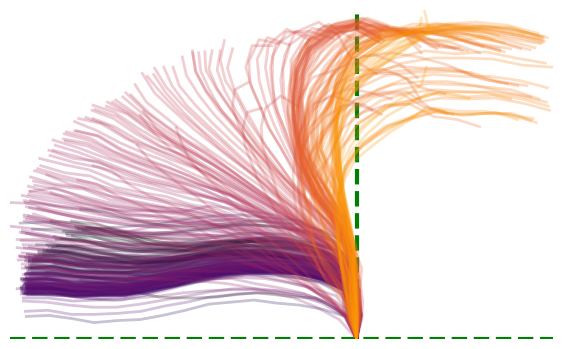

In [135]:
cmap = 'inferno'
cidx = np.round(np.linspace(0,200, len(cuscutas))).astype(int)
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].axhline(0, c='green', ls='--', lw=3, zorder=1)
ax[i].axvline(0, c='green', ls='--', lw=3, zorder=1)
for idx in range(len(cuscutas)):
    ax[i].plot(cuscutas[idx][:,1], cuscutas[idx][:,0], c=mpl.colormaps[cmap](cidx[idx]), lw=2, alpha=0.25, zorder=2);
ax[i].set_aspect('equal')
ax[i].set_facecolor('snow')
ax[i].axis('off')
ax[i].margins(0)
filename = dst + 'cuscutas_midaxis.pdf'
plt.savefig(filename, format='pdf', **savekw)

In [140]:
for k in range(len(swe)):
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax = np.atleast_1d(ax).ravel(); i = 0
    ax[i].scatter(*(swe[k].T), c='r', s=200, edgecolor='k')
    ax[i].set_xlim(swemin, swemax)
    ax[i].set_ylim(swemin, swemax)
    ax[i].set_aspect('equal')
    ax[i].set_facecolor('snow')
    #ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False);
    ax[i].tick_params(labelsize=20, labelcolor='w');

    filename = dst + 'swe_pca_{:02d}.pdf'.format(k)
    plt.savefig(filename, format='pdf', **savekw)
    plt.close()

In [58]:
#cc = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']*5

start = 0
for k in range(len(dmaxs)):
    stop = min([start + N, len(cuscutas)])
    
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax = np.atleast_1d(ax).ravel(); i = 0
    ax[i].axhline(0, c='green', ls='--', lw=3, zorder=1)
    ax[i].axvline(0, c='green', ls='--', lw=3, zorder=1)

    for idx in np.setdiff1d(np.arange(len(cuscutas)), np.arange(start, stop)):
        ax[i].plot(cuscutas[idx, :, 1], cuscutas[idx, :,0], c='lightgray', lw=2, alpha=0.15, zorder=2);
    for idx in range(start, stop):
        ax[i].plot(cuscutas[idx, :, 1], cuscutas[idx, :,0], c=mpl.colormaps[cmap](cidx[idx]), lw=2, alpha=0.25, zorder=3);
    start += N//2
    ax[i].set_aspect('equal')
    ax[i].set_facecolor('snow')
    ax[i].axis('off')
    filename = dst + 'cuscutas_midaxis_{:02d}.pdf'.format(k)
    print(filename)
    plt.savefig(filename, format='pdf', **savekw)
    plt.close()

../proc/emb/cuscutas_midaxis_00.pdf
../proc/emb/cuscutas_midaxis_01.pdf
../proc/emb/cuscutas_midaxis_02.pdf
../proc/emb/cuscutas_midaxis_03.pdf
../proc/emb/cuscutas_midaxis_04.pdf
../proc/emb/cuscutas_midaxis_05.pdf
../proc/emb/cuscutas_midaxis_06.pdf
../proc/emb/cuscutas_midaxis_07.pdf
../proc/emb/cuscutas_midaxis_08.pdf
../proc/emb/cuscutas_midaxis_09.pdf
../proc/emb/cuscutas_midaxis_10.pdf
../proc/emb/cuscutas_midaxis_11.pdf
../proc/emb/cuscutas_midaxis_12.pdf


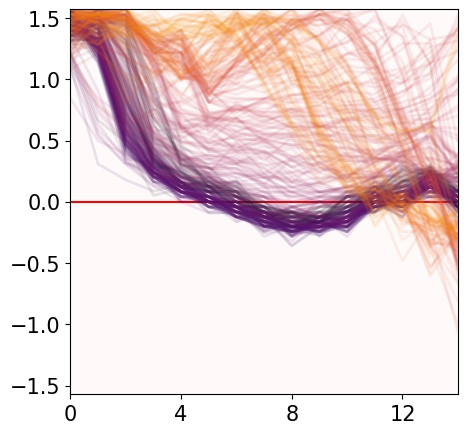

In [64]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = np.atleast_1d(ax).ravel(); i = 0
x = np.linspace(0,1, L)
x = np.arange(L)

ax[i].axhline(0, c='r', zorder=1);
for idx in range(len(degs)):
    ax[i].plot(x, rads[idx], c=mpl.colormaps[cmap](cidx[idx]), lw=2, alpha=0.1, zorder=2);
ax[i].set_ylim(-0.5*np.pi,0.5*np.pi)
ax[i].set_xlim(x[0],x[-1])
ax[i].set_facecolor('snow')
ax[i].tick_params(labelsize=15)
ax[i].set_xticks(np.arange(0,L,4), np.arange(0,L,4))

filename = dst + 'cuscutas_angle.pdf'
plt.savefig(filename, format='pdf', **savekw)

In [149]:
start = 0
for k in range(len(dmaxs)):
    stop = min([start + N, len(cuscutas)])
    
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax = np.atleast_1d(ax).ravel(); i = 0
    
    ax[i].axhline(0, c='r', zorder=1);
    ax[i].set_ylim(-0.5*np.pi,0.5*np.pi)
    ax[i].set_xlim(x[0],x[-1])
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=20, labelcolor='w')
    ax[i].set_xticks(np.arange(0,L,4), np.arange(0,L,4))
    
    for idx in np.setdiff1d(np.arange(len(cuscutas)), np.arange(start, stop)):
        ax[i].plot(x, rads[idx], c='lightgray', lw=2, alpha=0.1, zorder=2);
    for idx in range(start, stop):
        ax[i].plot(x, rads[idx], c=mpl.colormaps[cmap](cidx[idx]), lw=2, alpha=0.25, zorder=3);
    start += N//2
    
    filename = dst + 'cuscutas_angle_{:02d}.pdf'.format(k)
    print(filename)
    plt.savefig(filename, format='pdf', **savekw)
    plt.close()

../proc/emb/cuscutas_angle_00.pdf
../proc/emb/cuscutas_angle_01.pdf
../proc/emb/cuscutas_angle_02.pdf
../proc/emb/cuscutas_angle_03.pdf
../proc/emb/cuscutas_angle_04.pdf
../proc/emb/cuscutas_angle_05.pdf
../proc/emb/cuscutas_angle_06.pdf
../proc/emb/cuscutas_angle_07.pdf
../proc/emb/cuscutas_angle_08.pdf
../proc/emb/cuscutas_angle_09.pdf
../proc/emb/cuscutas_angle_10.pdf
../proc/emb/cuscutas_angle_11.pdf
../proc/emb/cuscutas_angle_12.pdf


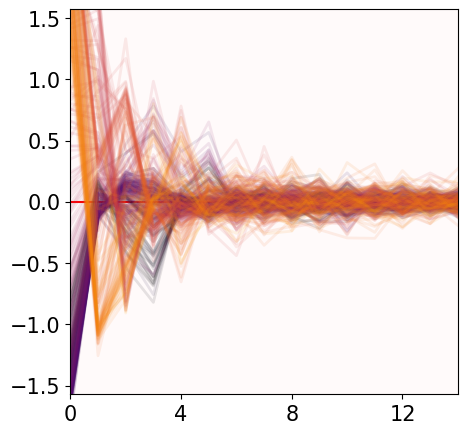

In [65]:
pcnum = 15
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].axhline(0, c='r', zorder=1);
for idx in range(len(degs)):
    ax[i].plot(x, pca[idx, :pcnum], c=mpl.colormaps[cmap](cidx[idx]), lw=2, alpha=0.1, zorder=2);
ax[i].set_ylim(-0.5*np.pi,0.5*np.pi)
ax[i].set_xlim(x[0],x[-1])
ax[i].set_facecolor('snow')
ax[i].tick_params(labelsize=15)
ax[i].set_xticks(np.arange(0,L,4), np.arange(0,L,4))

filename = dst + 'cuscutas_pca_angle.pdf'
plt.savefig(filename, format='pdf', **savekw)

In [67]:
start = 0
for k in range(len(dmaxs)):
    stop = min([start + N, len(cuscutas)])
    
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    ax = np.atleast_1d(ax).ravel(); i = 0
    
    ax[i].axhline(0, c='r', zorder=1);
    ax[i].set_ylim(-0.5*np.pi,0.5*np.pi)
    ax[i].set_xlim(x[0],x[-1])
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelsize=15)
    ax[i].set_xticks(np.arange(0,L,4), np.arange(0,L,4))
    
    for idx in np.setdiff1d(np.arange(len(cuscutas)), np.arange(start, stop)):
        ax[i].plot(x, pca[idx, :pcnum], c='lightgray', lw=2, alpha=0.1, zorder=2);
    for idx in range(start, stop):
        ax[i].plot(x, pca[idx, :pcnum], c=mpl.colormaps[cmap](cidx[idx]), lw=2, alpha=0.25, zorder=3);
    start += N//2
    
    filename = dst + 'cuscutas_pca_angle_{:02d}.pdf'.format(k)
    print(filename)
    plt.savefig(filename, format='pdf', **savekw)
    plt.close()

../proc/emb/cuscutas_pca_angle_00.pdf
../proc/emb/cuscutas_pca_angle_01.pdf
../proc/emb/cuscutas_pca_angle_02.pdf
../proc/emb/cuscutas_pca_angle_03.pdf
../proc/emb/cuscutas_pca_angle_04.pdf
../proc/emb/cuscutas_pca_angle_05.pdf
../proc/emb/cuscutas_pca_angle_06.pdf
../proc/emb/cuscutas_pca_angle_07.pdf
../proc/emb/cuscutas_pca_angle_08.pdf
../proc/emb/cuscutas_pca_angle_09.pdf
../proc/emb/cuscutas_pca_angle_10.pdf
../proc/emb/cuscutas_pca_angle_11.pdf
../proc/emb/cuscutas_pca_angle_12.pdf


In [146]:
c = ['orange', 'dodgerblue']
m = ['s', 'D']
xx = np.round(np.linspace(0, dmax, 5),1)
for k in range(len(dgms)):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax = np.atleast_1d(ax).ravel(); i = 0
    ax[i].axline( (0,0), slope=1, lw=2, c='r', zorder=1);
    for h in range(len(dgms[k])):
        ax[i].scatter(dgms[k][h][:,0], dgms[k][h][:,1], zorder=2, s=255, c=c[h], marker=m[h], edgecolor='k', label='$H_{}$'.format(h))
    ax[i].set_ylim(0, xx[-1]);
    ax[i].set_xlim(0, xx[-1]);
    ax[i].legend(loc = 'lower right', fontsize=28, borderpad=0.1, handletextpad=0.1);
    ax[i].tick_params(labelsize=20, labelcolor='w')
    ax[i].set_xticks(xx,xx)
    ax[i].set_yticks(xx,xx);
    #ax[i].set_xlabel('Birth', fontsize=18)
    #ax[i].set_ylabel('Death', fontsize=18)
    ax[i].set_facecolor('snow')
    
    filename = dst + 'diagram_{:02d}.pdf'.format(k)
    print(filename)
    plt.savefig(filename, format='pdf', **savekw)
    plt.close()

../proc/emb/diagram_00.pdf
../proc/emb/diagram_01.pdf
../proc/emb/diagram_02.pdf
../proc/emb/diagram_03.pdf
../proc/emb/diagram_04.pdf
../proc/emb/diagram_05.pdf
../proc/emb/diagram_06.pdf
../proc/emb/diagram_07.pdf
../proc/emb/diagram_08.pdf
../proc/emb/diagram_09.pdf
../proc/emb/diagram_10.pdf
../proc/emb/diagram_11.pdf
../proc/emb/diagram_12.pdf


In [147]:
for k in range(len(ple0)):
    pl0 = ple0[k].critical_pairs
    pl1 = ple1[k].critical_pairs
    
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax = np.atleast_1d(ax).ravel(); i = 0
    yy = np.round(np.linspace(0, plmax, 5),1)
    for j in range(len(pl0)):
        foo = np.vstack(pl0[j])
        ax[i].plot(foo[:,0], foo[:,1], zorder=2, c='r', label='$H_0$')
    for j in range(len(pl1)):
        foo = np.vstack(pl1[j])
        ax[i].plot(foo[:,0], foo[:,1], zorder=2, c='b', label='$H_1$')
    
    ax[i].tick_params(labelsize=20, labelcolor='w')
    ax[i].set_xticks(xx,xx)
    ax[i].set_yticks(yy,yy);
    h, l = ax[i].get_legend_handles_labels()
    ax[i].legend([h[0],h[-1]], [l[0],l[-1]], loc='upper right', fontsize=28, borderpad=0.1, handletextpad=0.1);
    ax[i].set_ylim(0, yy[-1])
    ax[i].set_xlim(0, xx[-1])
    ax[i].set_facecolor('snow');
    filename = dst + 'landscape_{:02d}.pdf'.format(k)
    print(filename)
    plt.savefig(filename, format='pdf', **savekw)
    plt.close()

../proc/emb/landscape_00.pdf
../proc/emb/landscape_01.pdf
../proc/emb/landscape_02.pdf
../proc/emb/landscape_03.pdf
../proc/emb/landscape_04.pdf
../proc/emb/landscape_05.pdf
../proc/emb/landscape_06.pdf
../proc/emb/landscape_07.pdf
../proc/emb/landscape_08.pdf
../proc/emb/landscape_09.pdf
../proc/emb/landscape_10.pdf
../proc/emb/landscape_11.pdf
../proc/emb/landscape_12.pdf


../proc/emb/avg_landscape.pdf


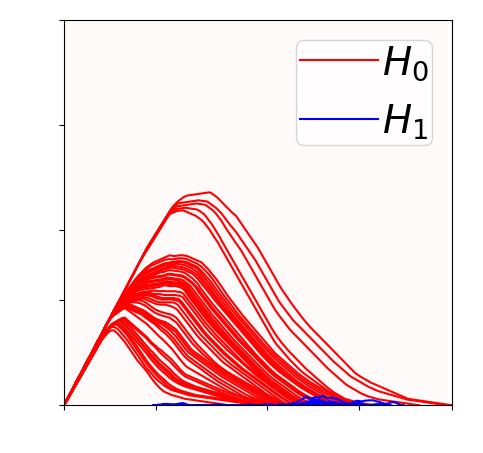

In [148]:
av0 = avg0.critical_pairs
av1 = avg1.critical_pairs

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = np.atleast_1d(ax).ravel(); i = 0

yy = np.round(np.linspace(0, plmax, 5),1)

for j in range(len(av0)):
    foo = np.vstack(av0[j])
    ax[i].plot(foo[:,0], foo[:,1], zorder=2, c='r', label='$H_0$')
for j in range(len(av1)):
    foo = np.vstack(av1[j])
    ax[i].plot(foo[:,0], foo[:,1], zorder=2, c='b', label='$H_1$')

ax[i].tick_params(labelsize=20, labelcolor='w')
ax[i].set_xticks(xx,xx)
ax[i].set_yticks(yy,yy);
h, l = ax[i].get_legend_handles_labels()
ax[i].legend([h[0],h[-1]], [l[0],l[-1]], loc='upper right', fontsize=28, borderpad=0.1, handletextpad=0.1);
ax[i].set_ylim(0, yy[-1])
ax[i].set_xlim(0, xx[-1])
ax[i].set_facecolor('snow');
filename = dst + 'avg_landscape.pdf'.format(k)
print(filename)
plt.savefig(filename, format='pdf', **savekw)